# Landcover fractions (Trees, Grass, Bare)

Following [Donohue 2009](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2486.2008.01746.x)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Analysis Parameters

In [2]:
# enter NDVI value of bare soil
ndvi_min = 0.141

# likely maximum NDVI
ndvi_max = 0.91

#ndvi data is here
ndvi_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NDVI_5km_monthly_1982_2022.nc'

## Open data

In [3]:
ds = xr.open_dataarray(ndvi_path)

## Calculate landcover fractions

In [4]:
#calculate f-total
ft = (ds - ndvi_min) / (ndvi_max - ndvi_min)
ft = xr.where(ft<0, 0, ft)
ft = xr.where(ft>1, 1, ft)

#calculate initial persistent fraction (equation 1 & 2 in Donohue 2009)
persist = ft.rolling(time=7, min_periods=1).min()
persist = persist.rolling(time=9, min_periods=1).mean()

#calculate initial recurrent fraction (equation 3 in Donohue 2009)
recurrent = ft - persist

###-------Skip equation 4 & 5 in Donohue 2009----------------
# persist = xr.where(recurrent<0, persist - np.abs(recurrent), persist) #eq4
# recurrent = ft - persist # eq 5
## ---------------------------------------------------------

#assign variable names
recurrent.name='grass'
persist.name='trees'

## Plots

Check how the fractions look for any given year

In [5]:
year='2022'

In [6]:
p = persist.sel(time=year).max('time')
r = recurrent.sel(time=year).max('time')
b = 1-(p+r)

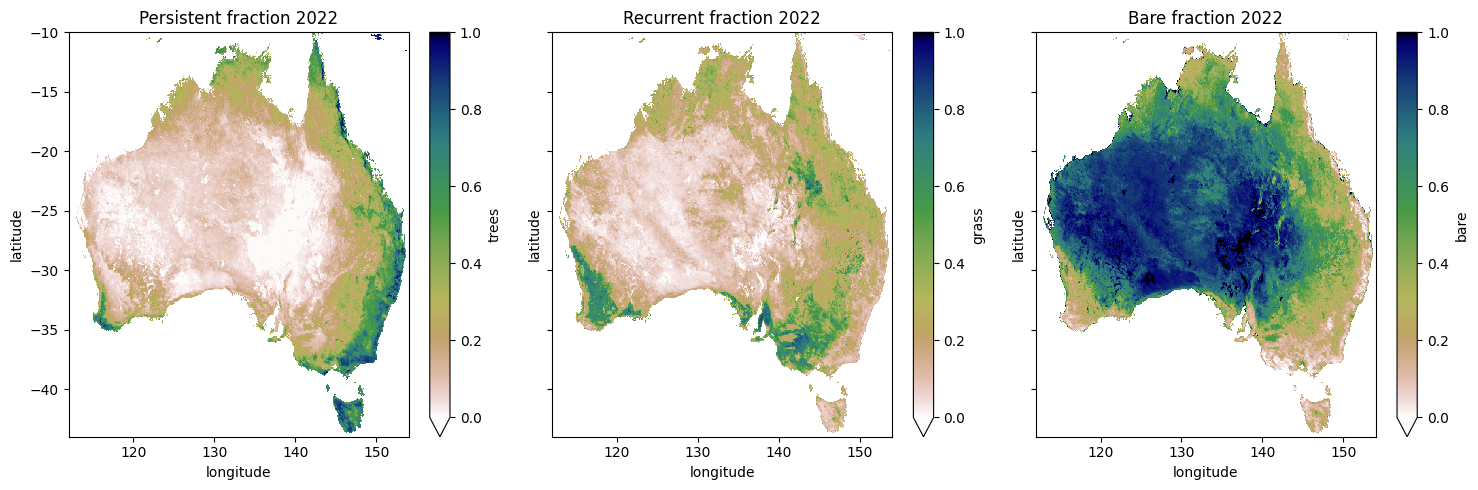

In [7]:
fig,ax=plt.subplots(1,3, figsize=(15,5), sharey=True)
p.plot.imshow(vmax=1, vmin=0, ax=ax[0], cmap='gist_earth_r') #v
r.plot.imshow(vmax=1, vmin=0,ax=ax[1], cmap='gist_earth_r')
b.rename('bare').plot.imshow(vmax=1, vmin=0,ax=ax[2], cmap='gist_earth_r')

ax[0].set_title('Persistent fraction '+year)
ax[1].set_title('Recurrent fraction ' +year)
ax[2].set_title('Bare fraction ' +year)
plt.tight_layout()

### Plot Aus-wide time-series

Text(0.5, 1.0, 'Mean fractions across Australia')

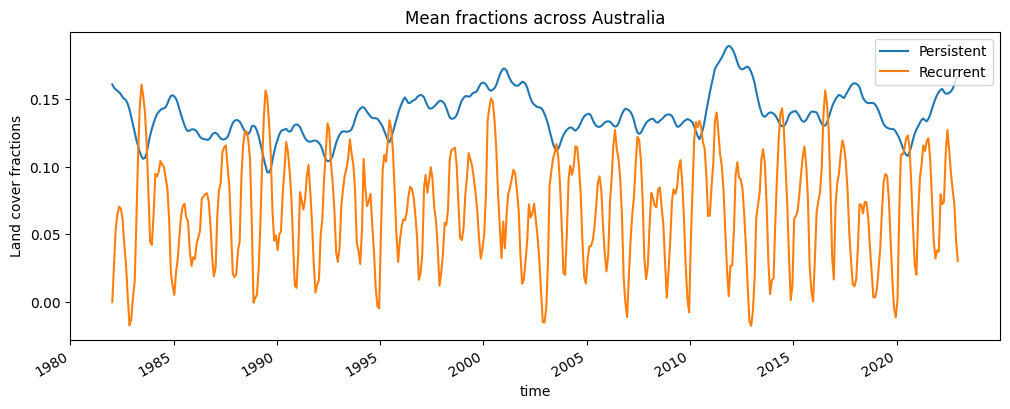

In [8]:
fig,ax=plt.subplots(1,1, figsize=(12,4))
persist.mean(['latitude', 'longitude']).plot(ax=ax, label='Persistent')
recurrent.mean(['latitude', 'longitude']).plot(ax=ax, label='Recurrent')
ax.legend()
plt.ylabel('Land cover fractions')
plt.title('Mean fractions across Australia')

# bare.mean(['latitude', 'longitude']).plot(ax=ax, label='bare')

## Aggregate to annual layers

Use the maximum fraction of trees and grass to create annual layers.

Bare soil is the residual

In [9]:
persist = persist.resample(time='1Y').max()
recurrent = recurrent.resample(time='1Y').max()
bare = 1-(persist+recurrent)
bare.name='bare'

### Export annual files 

In [10]:
persist.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/trees_5km_annual_1982_2022.nc')
recurrent.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/grass_5km_annual_1982_2022.nc')
bare.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/bare_5km_annual_1982_2022.nc')

## Create monthly timeseries for the flux modelling

In [11]:
import pandas as pd
from odc.geo.xr import assign_crs

In [12]:
dss_trees=[]
dss_grass=[]
dss_bare=[]
for y in bare.time.dt.year.values:
    # print(y)
    y = str(y)
    time = pd.date_range(y+"-01", y+"-12", freq='MS') 
    time = [t+pd.Timedelta(14, 'd') for t in time]

    #trees
    ds_persist = persist.sel(time=y).squeeze().drop('time')
    ds_persist = ds_persist.expand_dims(time=time)
    dss_trees.append(ds_persist)

    #grass
    ds_recurrent = recurrent.sel(time=y).squeeze().drop('time')
    ds_recurrent = ds_recurrent.expand_dims(time=time)
    dss_grass.append(ds_recurrent)

    ds_bare = bare.sel(time=y).squeeze().drop('time')
    ds_bare = ds_bare.expand_dims(time=time)
    dss_bare.append(ds_bare)

# join all the datasets back together
trees = xr.concat(dss_trees, dim='time').sortby('time')
grass = xr.concat(dss_grass, dim='time').sortby('time')
bare = xr.concat(dss_bare, dim='time').sortby('time')

# add right metadata
trees.attrs['nodata'] = np.nan
grass.attrs['nodata'] = np.nan
bare.attrs['nodata'] = np.nan

trees = assign_crs(trees, crs='EPSG:4326')
grass = assign_crs(grass, crs='EPSG:4326')
bare = assign_crs(bare, crs='EPSG:4326')



### Export data

In [13]:
trees.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/trees_5km_monthly_1982_2022.nc')
grass.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/grass_5km_monthly_1982_2022.nc')
bare.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/bare_5km_monthly_1982_2022.nc')